In [2]:
import numpy

from finance_utils.namedtuples import *
from finance_utils.uniontypes import *
from finance_utils.asset.spot.base import Spot,ServiceChargesSpot
# from finance_utils.asset.spot.strategy import SpotCostAveragingPlan
from finance_utils.strategy.dca import simple_dca, price_qualified_dca

from finance_utils.process.prices.gbm import RVDecoupledGBM, GBM, NormalDistribution
from finance_utils.trader.base import Trader
from finance_utils.trader.utility import *

from data_utils.stochastic_utils.distributions.nonParametricDistribution import HistogramDist, KernelMixDist, SmoothHisDist
from data_utils.stochastic_utils.random_process.correlatedRandom import random_correlated_series
from easy_datetime.timestamp import TimeStamp
import tqdm

from matplotlib import pyplot

In [3]:
class Test:
    def __init__(
            self, 
            weekdays=22,
            months=12,
    ):
        self.weekdays = weekdays
        self.months = months
        self.days = self.weekdays * self.months
        self.stocks:list[Spot] = []
        self.processes:list[RVDecoupledGBM] = []
        
    def new_processes(self, rr=(0.03, 0.03), v=(0.015, 0.015), s0=(1,1), lot_size=(100,100), corr=(0,0)):
        self.stocks = []
        self.processes = []
        
        num = len(rr)
        d = []
        for i in range(num):
            d.append(NormalDistribution(rr[i] / self.days, v[i]))
            
        if num > 1:
            rs = random_correlated_series(d, corr, self.days)
        else:
            rs = [d[0].rvf(self.days)]
        for i in range(num):
            self.stocks.append(
                ServiceChargesSpot(f"{i}", lot_size[i], TradeDelta("day", 1), 5e-5, 5e-4)
            )
            self.processes.append(
                RVDecoupledGBM(f"{i}", rs[i], s0[i], TimeStamp.now().accurate_to("year"), "day", 1)
            )
            
    def path_data(self):
        d = []
        for p in self.processes:
            d.append(p.price)
        return d
        
        
            
    def simple_dca_trade(self, capital, trade_interval = 1):
        index_list = []
        yield_list = []
        trigger_set = set(range(0, self.days, trade_interval))
        cap = capital / len(trigger_set)
        
        
        num = len(self.stocks)
        simple_traders = [Trader(f"s_trader_{i}", capital, None) for i in range(num)]
        
        for i, t, _ in self.processes[0].process_iter():
            trader_yield = 0
            index_yield = 0
            for n in range(num):
                path = self.processes[n][i]
                index_yield += path.price
                
                _, _ = simple_dca(self.processes[n].s0, i, t, path, self.stocks[n], simple_traders[n], cap, trigger_set)
                trader_yield += simple_traders[n].net_worth_rate(**path.dic)
            index_list.append(index_yield / num)
            yield_list.append(trader_yield/ num)
            
        return index_list, yield_list
    
    def price_qualified_dca_trade(self, capital, pr=0.99,sr=1.01, trade_interval = 1):
        index_list = []
        yield_list = []
        trigger_set = list(range(0, self.days, trade_interval))
        
        unit_cap = capital / len(trigger_set)
           
        num = len(self.stocks)
        price_qualified_traders = [Trader(f"p_trader_{i}", capital, None) for i in range(num)]
        
        for i, t, _ in self.processes[0].process_iter():
            trader_yield = 0
            index_yield = 0
            for n in range(num):
                if i in trigger_set:
                    cap = price_qualified_traders[n].capital - len(trigger_set[trigger_set.index(i):]) * unit_cap
                else:
                    pass
                path = self.processes[n][i]
                index_yield += path.price
                
                _, _ = price_qualified_dca(self.processes[n].s0, i, t, path, self.stocks[n], price_qualified_traders[n], cap, trigger_set, pr, sr)
                trader_yield += price_qualified_traders[n].net_worth_rate(**path.dic)
            index_list.append(index_yield / num)
            yield_list.append(trader_yield/ num)
            
        return numpy.array(index_list), numpy.array(yield_list)

In [4]:
test = Test(
    22,
    12
)


In [5]:
test.new_processes([0.03] * 1, [0.17] * 1,  (1,1),(100,100), [0] * 1)

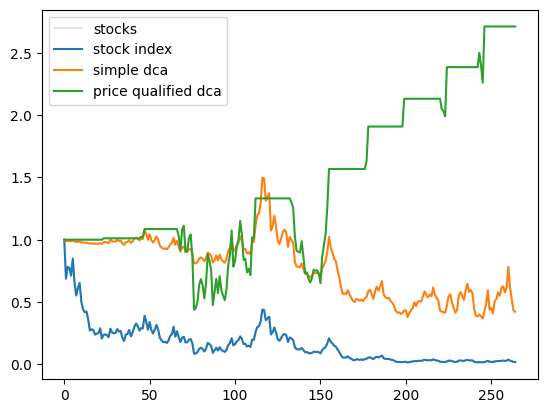

In [6]:
p = test.path_data()

spot, sdt = test.simple_dca_trade(200*12,22)
_, pqdt = test.price_qualified_dca_trade(200*12, 0.9, 1.1, 22)

for i, pi in enumerate(p):
    if i == 0:
        pyplot.plot(pi, alpha=0.2, color="gray", label="stocks")
    else:
        pyplot.plot(pi, alpha=0.2, color="gray")

pyplot.plot(spot, label="stock index")
pyplot.plot(sdt, label="simple dca")
pyplot.plot(pqdt, label="price qualified dca")
pyplot.legend()
pyplot.show()

In [18]:
epoch = 2000
spot_list = []
std_list = []
for _ in tqdm.trange(epoch):
    test.new_processes([0.03] * 1, [0.015] * 1, (1,1), (100,100),[0] * 1)
    spot, sdt = test.simple_dca_trade(200 * 12,22)
    spot_list.append(spot)
    std_list.append(sdt)
spot_array = numpy.array(spot_list)
std_array = numpy.array(std_list)

100%|██████████| 2000/2000 [00:24<00:00, 80.35it/s]


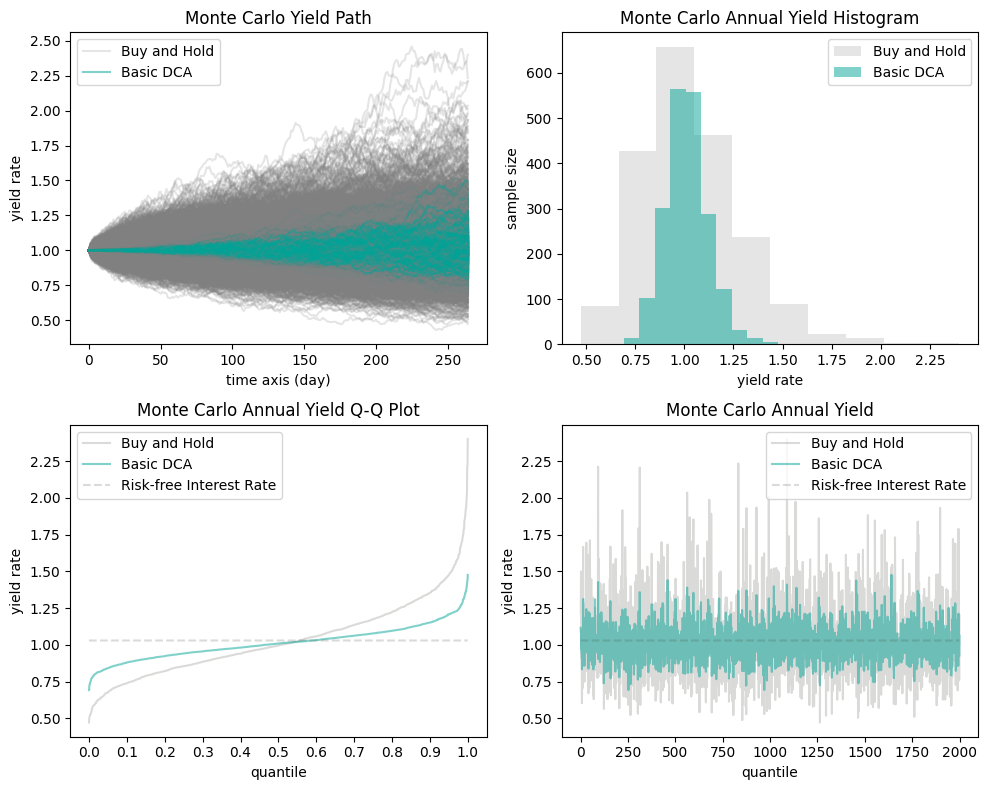

In [33]:
pyplot.figure(figsize=(10, 8))
pyplot.subplot(2,2,1)
for i in range(epoch):
    if i == 0:
        kwargs1 = {"label":"Buy and Hold"}
        kwargs2 = {"label":"Basic DCA"}
    else:
        kwargs1 = {}
        kwargs2 = {}
    pyplot.plot(spot_array[i], color="gray", alpha=0.2, **kwargs1)
    pyplot.plot(std_array[i], color="#00a497", alpha=0.5, **kwargs2)


pyplot.title("Monte Carlo Yield Path")
# pyplot.title("Buying frequency: Monthly")
pyplot.xlabel("time axis (day)")
pyplot.ylabel("yield rate")
pyplot.legend()

pyplot.subplot(2,2,2)
pyplot.hist(spot_array[:,-1],color="gray", alpha=0.2, label="Buy and Hold")
pyplot.hist(std_array[:,-1],  color="#00a497", alpha=0.5, label="Basic DCA")
pyplot.title("Monte Carlo Annual Yield Histogram")
# pyplot.title("Buying frequency: Monthly")
pyplot.xlabel("yield rate")
pyplot.ylabel("sample size")
pyplot.legend()
# pyplot.yticks(range(0,120,20), [f"{i * 20}" for i in range(0,120,20)])

pyplot.subplot(2,2,3)
pyplot.plot(numpy.sort(spot_array[:,-1]),color="#494a41", alpha=0.2, label="Buy and Hold")
pyplot.plot(numpy.sort(std_array[:,-1]),  color="#00a497", alpha=0.5, label="Basic DCA")
pyplot.plot([1.03] * epoch,  color="#494a41", alpha=0.2, label="Risk-free Interest Rate", linestyle="--")
# pyplot.suptitle("Monte Carlo Annual Yield Histogram(Sorted)")
pyplot.title("Monte Carlo Annual Yield Q-Q Plot")
pyplot.xlabel("quantile")
pyplot.ylabel("yield rate")
pyplot.xticks(range(0, 2200, 200), [f"{i/2000}" for i in range(0,2200,200)])
pyplot.legend()

pyplot.subplot(2,2,4)
# index = numpy.where(spot_array[:,-1]>=1.03)
pyplot.plot(spot_array[:,-1],color="#494a41", alpha=0.2, label="Buy and Hold")
pyplot.plot(std_array[:,-1],  color="#00a497", alpha=0.5, label="Basic DCA")
pyplot.plot([1.03] * epoch,  color="#494a41", alpha=0.2, label="Risk-free Interest Rate", linestyle="--")
pyplot.title("Monte Carlo Annual Yield")
# pyplot.title("Buying frequency: Monthly")
pyplot.xlabel("quantile")
pyplot.ylabel("yield rate")
pyplot.legend()

pyplot.tight_layout()
pyplot.show()

In [12]:
print(numpy.mean(spot_array[:,-1]))
print(numpy.mean(std_array[:,-1]))

1.0219030418956307
1.0087210425158484


In [13]:
def sharp(xlist, rr=1.03):
    r = xlist - rr
    return numpy.mean(r)/numpy.std(r, ddof=1)

In [14]:
s = 0
for i in range(epoch):
    s+= sharp(spot_array[i])
print(s/epoch)

s = 0
for i in range(epoch):
    s+= sharp(std_array[i])
print(s/epoch)

-0.4142303774203189
-0.9002322135274934


In [15]:
from easy_utils.number_utils.number_utils import EasyFloat
mean_bdca = []
mean_spot = []
sharp_bdca = []
for i,v in enumerate(EasyFloat.frange(0.01,0.3,0.01)):
    epoch = 500
    spot_list = []
    std_list = []
    for _ in tqdm.trange(epoch):
        test.new_processes([0.03] * 1, [v] * 1, (1,1), (100,100),[0] * 1)
        spot, sdt = test.simple_dca_trade(2000 * 12, 22)
        spot_list.append(spot)
        std_list.append(sdt)
    spot_array = numpy.array(spot_list)
    std_array = numpy.array(std_list)
    a = 0
    b= 0
    for j in range(epoch):
        a +=sharp(spot_array[i])
        b+=sharp(std_array[i])
    # print([i,numpy.mean(spot_array[:,-1]), a/epoch])
    # print([i,numpy.mean(std_array[:,-1]), b/epoch])
    mean_bdca.append(numpy.mean(std_array[:,-1]))
    mean_spot.append(numpy.mean(spot_array[:,-1]))
    sharp_bdca.append(b)

100%|██████████| 500/500 [00:05<00:00, 90.27it/s]


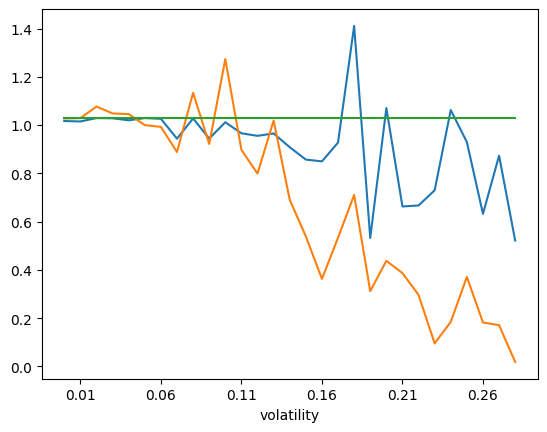

In [16]:
# pyplot.plot(mean_spot)
data = numpy.array(mean_bdca)
pyplot.plot(
    data
)
pyplot.plot(
    mean_spot
)
pyplot.plot([1.03] * 29)
pyplot.xticks(range(1,30,5), EasyFloat.frange(0.01,0.3,0.05))
pyplot.xlabel("volatility")
pyplot.show()
# pyplot.plot(sharp_bdca)
# pyplot.show()